Study the properties of each adjacency matrix


In [1]:
import os, sys

class FileSystem:
  def __init__(self, colab_dir="ntds_2019", local_dir="./", data_dir="data"):
    IN_COLAB = 'google.colab' in sys.modules
    if (IN_COLAB):
      from google.colab import drive
      drive.mount('/gdrive')
      self.root_dir = os.path.join("/gdrive/My Drive/", colab_dir)
    else:
      self.root_dir = local_dir
    self.data_dir = data_dir
    self.change_directory = False

  def data_path(self, name):
    return os.path.join(self.data_dir, name) if self.change_directory else os.path.join(self.root_dir, self.data_dir, name)

  def path(self, name):
    return os.path.join("./", name) if self.change_directory else os.path.join("./", self.root_dir, name)

  def cd(self):
    %cd {self.root_dir}
    %ls
    self.change_directory = True

fs = FileSystem()
fs.cd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/ntds_2019
archives/                     graph_label_propagation.ipynb
CreateAdjacencyMatrix.ipynb   kNN_ingredient_replacement.ipynb
data/                         Network_Tour_Project_Summary.pdf
GCNN.ipynb                    ntdsV2.ipynb
graph_communities_V2.0.ipynb  papers/
graphFiltering.ipynb          recipe-cleaner.py
graphics/                     StudyingGraphProperties.ipynb


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import itertools
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import community

Function Definitions

In [0]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    D = np.diag(np.sum(adjacency, 1)) # Degree matrix
    combinatorial = D - adjacency
    if normalize:
        D_norm = np.diag(np.clip(np.sum(adjacency, 1), 1, None)**(-1/2))
        return D_norm @ combinatorial @ D_norm
    else:
        return combinatorial
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    return np.linalg.eigh(laplacian)
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    return np.count_nonzero(lamb <= threshold)


Load Adjacency Matrices

In [0]:
recipe_ingredients_coocurrence_allingr = np.load(fs.data_path('Ingredient_Adjacency_Matrix.npy'))
recipe_ingredients_coocurrence_firstword = np.load(fs.data_path('Ingredient_Adjacency_Matrix_First_Word.npy'))
recipes_sparsified = np.load(fs.data_path('Ingredient_Adjacency_Matrix_Sparsified.npy'))
nutrition_info = np.load(fs.data_path('Ingredient_Adjacency_Matrix_USDA_Nutrition_Info.npy'))
nutrition_info_normalized = np.load(fs.data_path('Ingredient_Adjacency_Matrix_USDA_Nutrition_Info_Normalized.npy'))
combined_recipe_nutrition = np.load(fs.data_path('Ingredient_Adjacency_Matrix_Combined.npy'))
combined_recipe_nutrition_norm = np.load(fs.data_path('Ingredient_Adjacency_Matrix_Combined_Normalized.npy'))
combined_recipe_nutrition_addition = np.load(fs.data_path('Ingredient_Adjacency_Matrix_Combined_Addition.npy'))
combined_recipe_nutrition_addition_mean = np.load(fs.data_path('Ingredient_Adjacency_Matrix_Combined_Addition_Mean.npy'))
combined_recipe_nutrition_mult = np.load(fs.data_path('Ingredient_Adjacency_Matrix_Combined_Multiplication.npy'))

In [0]:
ingredient_list_full = np.load(fs.data_path('Ingredient_List.npy'))
ingredient_list_firstword = np.load(fs.data_path('Ingredient_List_First_Word.npy'))
ingredient_list_usda = np.load(fs.data_path('Ingredient_List_USDA_Nutrition_Info.npy'))

In [0]:
def studyMatrixProperties(adj_mat, ingredient_list):
  feature_graph = nx.from_numpy_matrix(adj_mat)
  nn = feature_graph.number_of_nodes()
  ne = feature_graph.number_of_edges()
  print('Number of nodes: {}, Number of edges: {}'.format(nn, ne))

  laplacian = compute_laplacian(adj_mat,True)
  lamb_norm, U_norm = spectral_decomposition(laplacian)
  conn_comp = compute_number_connected_components(lamb_norm,threshold=1e-12)
  print('Number of connected compopents: {0}'.format(conn_comp))
  if conn_comp == 1:
    diam = nx.diameter(feature_graph)
    print('Network diameter: {0}'.format(diam))
  sparsity = np.isnan(adj_mat).sum()/(adj_mat.shape[0]*2)
  print('Sparsity: {0}%'.format(sparsity*100))

  cc = nx.average_clustering(feature_graph)
  print('Clustering coefficient: {0}'.format(cc))

  #Use degree centrality to find hub ingredients
  centr = nx.degree_centrality(feature_graph)
  centrality_array = np.array(list(centr.items()))[:,1]
  centr_mean = np.mean(centrality_array)
  centr_std = np.std(centrality_array)
  indices = np.where(centrality_array > centr_mean + 2*centr_std )
  hubs = ingredient_list[indices]
  if len(hubs) > 0:
    print("Hub ingredients: {}".format(hubs))
  else:
    print("No hub ingredients")

  part = community.best_partition(feature_graph)
  mod = community.modularity(part,feature_graph) 
  print('Modularity: {0}'.format(mod))

  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(lamb_norm)
  plt.xlabel('Index')
  plt.ylabel('Eigenvalue')
  plt.title('Eigenvalues $L_{norm}$')
  plt.show()

  plt.figure(figsize=(12,5))
  plt.subplot(1,2,2)
  plt.title('Ingredient graph')
  plt.xlabel('Degree')
  plt.ylabel('Frequency')
  degrees = [degree for node, degree in feature_graph.degree()]
  plt.hist(degrees);
  plt.show()
  

Number of nodes: 357, Number of edges: 26061
Number of connected compopents: 1
Network diameter: 3
Sparsity: 0.0%
Clustering coefficient: 0.7581120793331181
Hub ingredients: ['butter, without salt' 'honey' 'lemon juice, raw'
 'milk, fluid, 1% fat, without added vitamin a and vitamin d'
 'oil, olive, salad or cooking' 'salt, table' 'spices, garlic powder'
 'spices, pepper, black' 'sugars, brown' 'sugars, granulated'
 'water, bottled, generic' 'wheat flour, white, all-purpose, unenriched']
Modularity: 0.19393510026573776


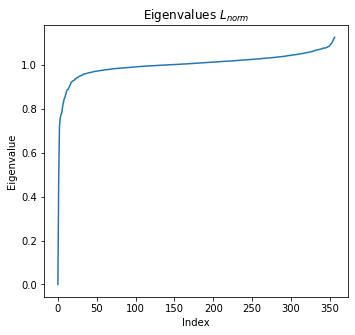

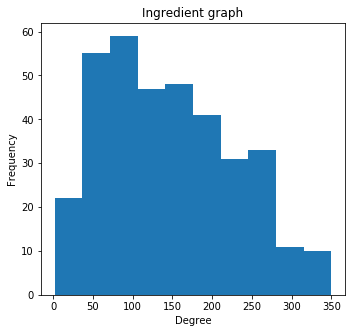

In [32]:
studyMatrixProperties(recipe_ingredients_coocurrence_allingr,ingredient_list_full)

Number of nodes: 213, Number of edges: 10810
Number of connected compopents: 1
Network diameter: 3
Sparsity: 0.0%
Clustering coefficient: 0.7860501427063846
Hub ingredients: ['oil' 'salt' 'spices' 'sugars' 'water']
Modularity: 0.14051991441533881


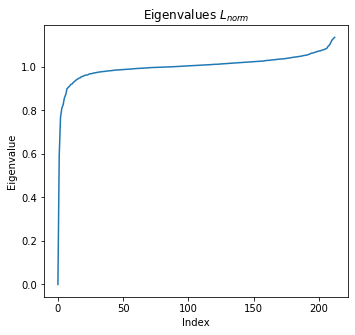

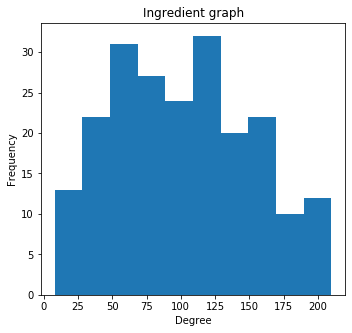

In [33]:
studyMatrixProperties(recipe_ingredients_coocurrence_firstword, ingredient_list_firstword)

Number of nodes: 357, Number of edges: 52031
Number of connected compopents: 28
Sparsity: 0.0%
Clustering coefficient: 0.8979877352056108
No hub ingredients
Modularity: 0.0020958223433844973


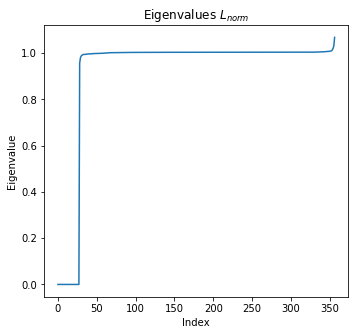

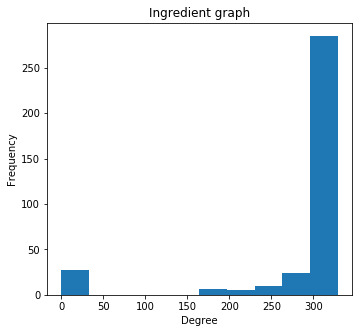

In [34]:
studyMatrixProperties(recipes_sparsified,ingredient_list_full)

Number of nodes: 313, Number of edges: 22241
Number of connected compopents: 10
Sparsity: 0.0%
Clustering coefficient: 0.8550008545182112
No hub ingredients
Modularity: 0.15704473680471373


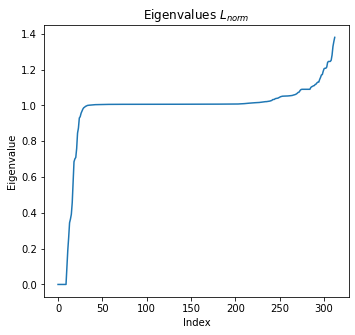

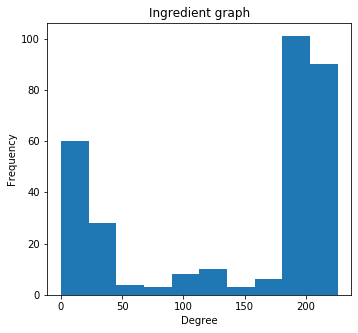

In [35]:
studyMatrixProperties(nutrition_info,ingredient_list_usda)

Number of nodes: 313, Number of edges: 36738
Number of connected compopents: 6
Sparsity: 0.0%
Clustering coefficient: 0.9376731215895305
No hub ingredients
Modularity: 0.07677369944825757


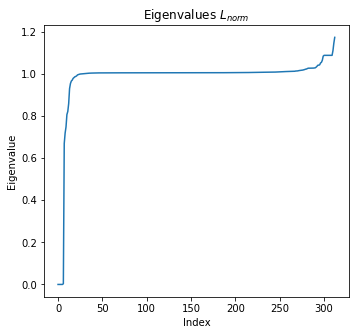

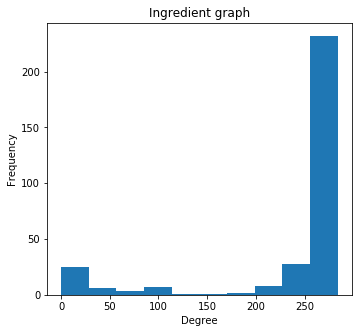

In [36]:
studyMatrixProperties(nutrition_info_normalized, ingredient_list_usda)

Number of nodes: 313, Number of edges: 30713
Number of connected compopents: 6
Sparsity: 0.0%
Clustering coefficient: 0.9100225273187402
No hub ingredients
Modularity: 0.09891342005978765


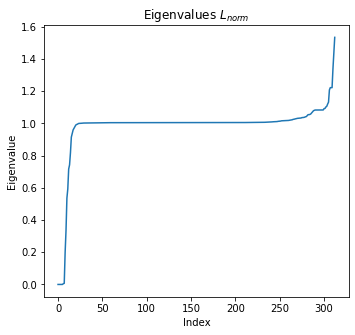

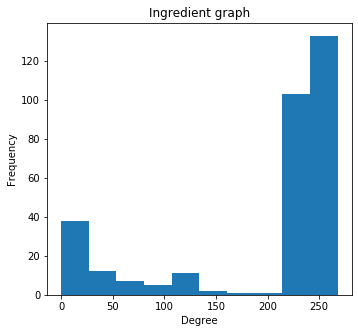

In [37]:
studyMatrixProperties(combined_recipe_nutrition, ingredient_list_usda)

Number of nodes: 313, Number of edges: 34662
Number of connected compopents: 40
Sparsity: 0.0%
Clustering coefficient: 0.8487214905694603
No hub ingredients
Modularity: 0.0034015538303263926


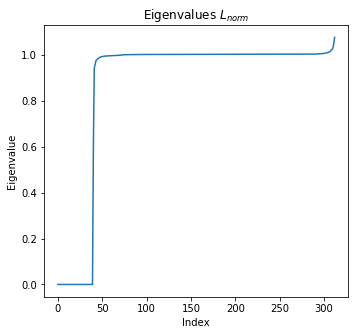

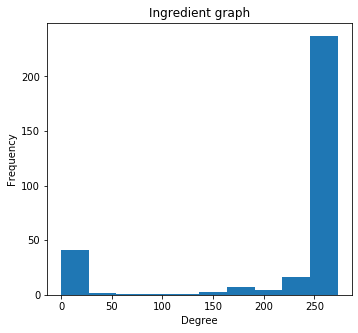

In [38]:
studyMatrixProperties(combined_recipe_nutrition_norm, ingredient_list_usda)

Number of nodes: 313, Number of edges: 42759
Number of connected compopents: 1
Network diameter: 2
Sparsity: 0.0%
Clustering coefficient: 0.9362175102414722
No hub ingredients
Modularity: 0.07695295586860633


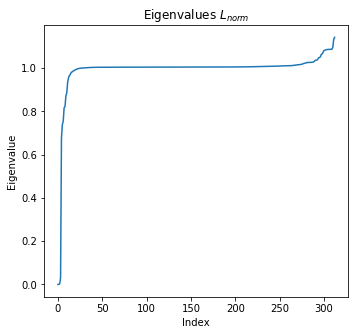

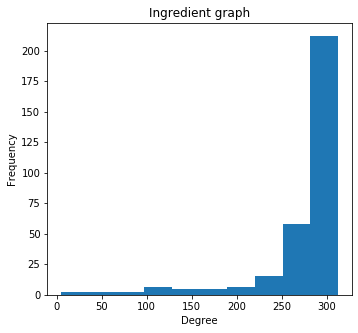

In [39]:
studyMatrixProperties(combined_recipe_nutrition_addition, ingredient_list_usda)

Number of nodes: 313, Number of edges: 42759
Number of connected compopents: 1
Network diameter: 2
Sparsity: 0.0%
Clustering coefficient: 0.9362175102414722
Modularity: 0.24003388209209864


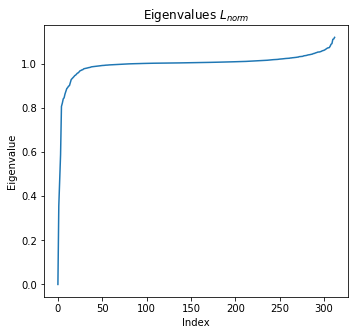

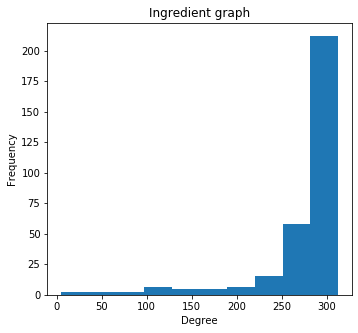

In [0]:
studyMatrixProperties(combined_recipe_nutrition_addition_mean)

Number of nodes: 313, Number of edges: 15733
Number of connected compopents: 6
Sparsity: 0.0%
Clustering coefficient: 0.6956780533794216
Hub ingredients: ['butter, without salt' 'lemon juice, raw'
 'milk, fluid, 1% fat, without added vitamin a and vitamin d'
 'spices, garlic powder' 'spices, pepper, black' 'water, bottled, generic'
 'wheat flour, white, all-purpose, unenriched']
Modularity: 0.2859243255454995


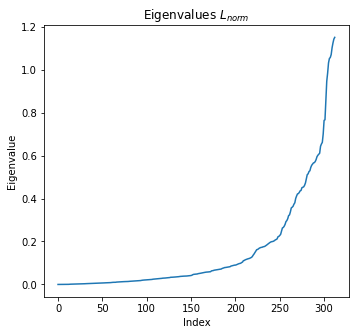

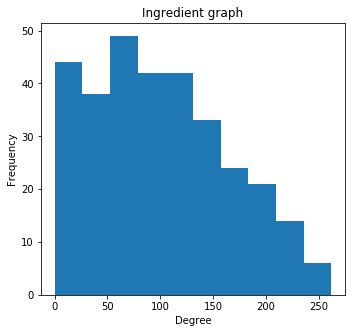

In [40]:
studyMatrixProperties(combined_recipe_nutrition_mult, ingredient_list_usda)